# Introduction to mode-based imaging

`PLsim` simulates observation with a photonic lantern placed at the focal plane. The photonic lantern's input entrance is a multimode fiber, which supports a few number of spatial modes to propagate through the device. The amplitudes coupled to these modes are coherently mixed (by a complex transfer matrix, determined by the design and construction of the lantern) to produce single-moded output amplitudes in the single-mode fibers. In essense, a photonic lantern is a mode-converter; what we can observe through the lantern are intensities of the single-moded beams, whose complex amplitudes correspond to the linear combination of input mode amplitudes. 


Observation through a lantern is a form of "spatial mode-based imaging", or "SPADE (Spatial mode demultiplexing)". The focal plane field is projected onto a set of spatial modes and the mode amplitudes are measured. SPADE can be implemented in other ways too, such as multi-plane light conversion (MPLC).

`PLsim`, althogh the name suggests this is for photonic lanterns, is a general simulation tool for mode-based imaging instruments. This notebook explains what mode-based imaging is, and describes how `PLsim` simulates it.

## The model of observables

Basically, the lantern output intensities $I$ (or any spatial-mode-based imaging instrument's outputs) can be described by this simple equation:

$$
I=\text{diag}\big(U \left[ \int \Gamma \cdot \mathbf{K} \right] U^\dagger \big)
$$

where $U$ is the transfer matrix of the mode-based-imaging device, $\mathbf{K}$ is the optical transfer function (OTF) matrix, and $\Gamma$ is the mutual coherence function. Each of these will be explained in detail throughout this notebook. `PLsim` takes a modular design to simulate these three separately.

### 1. The mutual coherence function $\Gamma$

For incoherent sources, the mutual coherence function is nothing but the Fourier transform of the intensity distribution (image) by Van Cittert-Zernike theorem, and is defined on the $uv$ plane.

`PLsim` has a class for computing mutual coherence functions of point sources and simple geometries (uniform disk, gaussian). Here are examples:

In [1]:
import hcipy as hc
import numpy as np
import matplotlib.pyplot as plt

from PLsim.scene import Scene

# Define pupil grid
ndim = 125
diameter = 10
pupil_grid = hc.make_pupil_grid(ndim, diameter)

ref_wavelength = 1.55e-6

scene = Scene(pupil_grid, ref_wavelength)

Simulate the mutual coherence function for a point source offsetted at 5 mas

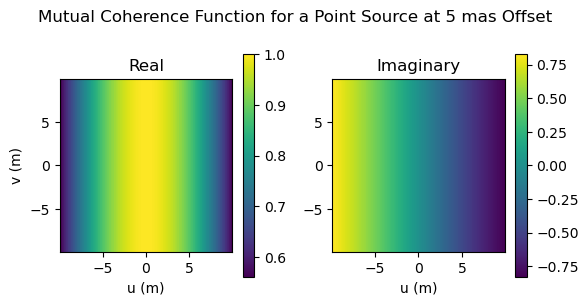

In [2]:
xoffset = 5e-3/206265 # 5 mas in rad
yoffset = 0

out_mutual_coherence = scene.J_point(xoffset, yoffset)

fig, axs = plt.subplots(ncols=2, figsize=(6,3))
p1=hc.imshow_field(np.real(out_mutual_coherence), grid = scene.egrid, ax=axs[0])
p2=hc.imshow_field(np.imag(out_mutual_coherence), grid = scene.egrid, ax=axs[1])
plt.colorbar(p1, ax=axs[0])
plt.colorbar(p2, ax=axs[1])
axs[0].set_title('Real')
axs[1].set_title('Imaginary')

axs[0].set_ylabel('v (m)')
axs[0].set_xlabel('u (m)')
axs[1].set_xlabel('u (m)')
fig.suptitle('Mutual Coherence Function for a Point Source at 5 mas Offset')
fig.tight_layout()

plt.show()

Another example at 50 mas

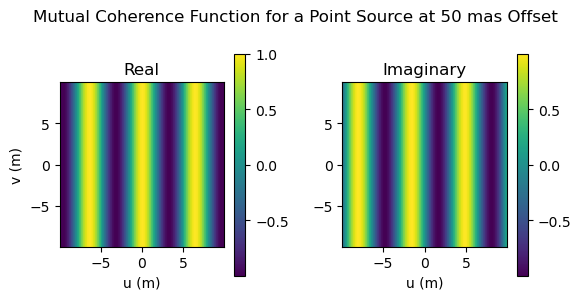

In [3]:
xoffset2 = 50e-3/206265 # 50 mas in rad
yoffset2 = 0

out_mutual_coherence = scene.J_point(xoffset2, yoffset2)

fig, axs = plt.subplots(ncols=2, figsize=(6,3))
p1=hc.imshow_field(np.real(out_mutual_coherence), grid = scene.egrid, ax=axs[0])
p2=hc.imshow_field(np.imag(out_mutual_coherence), grid = scene.egrid, ax=axs[1])
plt.colorbar(p1, ax=axs[0])
plt.colorbar(p2, ax=axs[1])
axs[0].set_title('Real')
axs[1].set_title('Imaginary')

axs[0].set_ylabel('v (m)')
axs[0].set_xlabel('u (m)')
axs[1].set_xlabel('u (m)')
fig.suptitle('Mutual Coherence Function for a Point Source at 50 mas Offset')
fig.tight_layout()
plt.show()

Comparing the two, larger the spatial scales, smaller the fringe scales in the mutual coherence function!

Now we will move on to an explanation of how a mode-sorting instrument samples these mutual coherence functions.

### 2. The OTF matrix $\mathbf{K}$

Mode-sorter's each output complex amplitude corresponds to a specific mode at the focal plane, called the photonic lantern principal mode (PLPM; [Kim et al. 2024a](https://iopscience.iop.org/article/10.3847/1538-4357/ad245e)). The physical interpretation of PLPM is that, if the input field shape is exactly matched to this mode, all the light would be routed to this specific output. 

The Fourier-transformed PLPM, or pupil-plane PLPM, when multiplied by the telescope's aperture, is like an "effective aperture" or "effective pupil function". Let us denote $j$ th output fiber's effective pupil function as $X_{p,j}$. For a lantern with $N$ number of outputs, it has $N$ different effective apertures.

The OTF matrix $\mathbf{K}$ is defined as cross-correlation of a pair of effective pupil functions seen by each mode (output). For example, for $j$ th and $k$ th pupil-plane modes:
$$
\mathbf{K}_{j,k}(\mathbf{b}) \equiv  \,(X_{p,j} \star X_{p,k})(\mathbf{b})
$$
where $\star$ represents the cross-correlation.

Note that, conventionally an OTF is an autocorrelation of telescope's aperture function, and represents the spatial frequency sampled by such an aperture. This OTF matrix is a generalized version of it --- it is an $N\times N$ matrix encoding how each pair of modes samples spatial frequencies. The mode-sorting system therefore probes the mutual coherence function through a set of weighted spatial-frequency filters, providing access to interferometric information.

`PLsim` has a class for computing the OTF matrix, under the `otf` module. Here I show an example for a 3-moded fiber-based mode-sorting system (i.e., 3-port photonic lantern).

`OTF.from_fiber_params()` computes LP modes from the user-provided fiber modes.

In [4]:
from PLsim.otf import OTF

# Fiber parameters. Note these determine the number of supported modes
ncore = 1.444
nclad = 1.444 - 5.5e-3
rcore = 6e-6  # 6 microns
wavelength = 1.55e-6  # 1550 nm

# Grids
focal_plane_resolution = 0.5e-6  # 0.5 micron per pixel
focal_length = diameter * 5 # focal ratio of 5


focal_grid = hc.make_pupil_grid(ndim, focal_plane_resolution * ndim)

# Telescope aperture (circular)
aperture = hc.make_circular_aperture(diameter)(pupil_grid)

otf = OTF.from_fiber_params(ncore, nclad, rcore, wavelength,
                            focal_grid, pupil_grid, focal_length,
                            aperture, optimize_focal_length = False)

Supported modes:  ['LP01', 'LP11a', 'LP11b']
Number of modes:  3


Now let's show how the focal-plane modes look like.

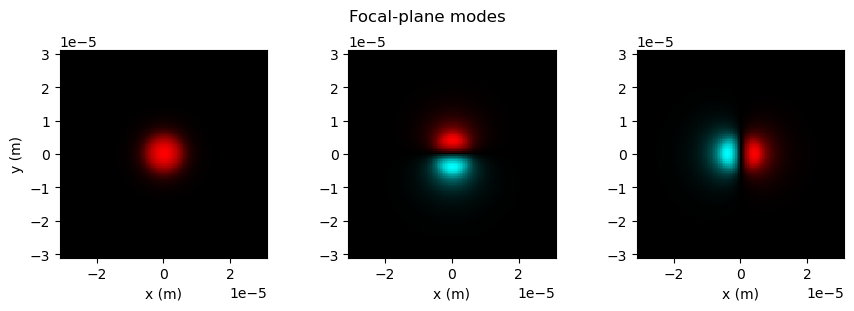

In [5]:
fig, axs = plt.subplots(ncols=3, figsize=(9,3))
for i in range(3):
    hc.imshow_field(otf.focal_modes[i], grid = focal_grid, ax=axs[i])
    axs[i].set_xlabel('x (m)')
fig.suptitle('Focal-plane modes')
axs[0].set_ylabel('y (m)')
fig.tight_layout()
plt.show()

These are the LP01, LP11a, and LP11b modes, the three lowest LP modes.

Propagating these modes to the pupil plane and multiplying by the telescope's aperture function, we get the effective pupil functions of each fiber.

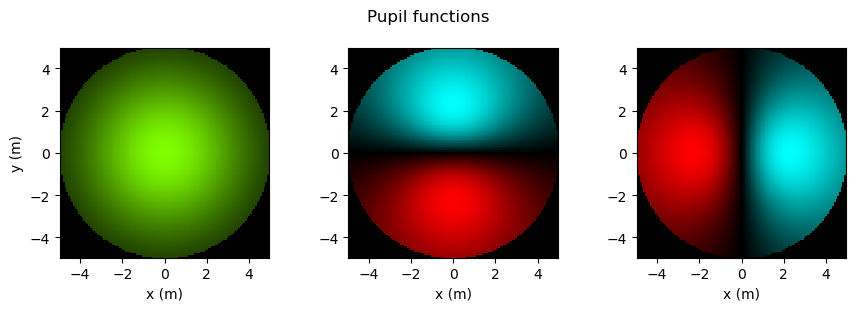

In [6]:
fig, axs = plt.subplots(ncols=3, figsize=(9,3))
for i in range(3):
    hc.imshow_field(otf.pupil_functions[i], grid = pupil_grid, ax=axs[i])
    axs[i].set_xlabel('x (m)')
fig.suptitle('Pupil functions')
axs[0].set_ylabel('y (m)')
fig.tight_layout()
plt.show()

Do `otf.compute()` to compute the OTF matrix.

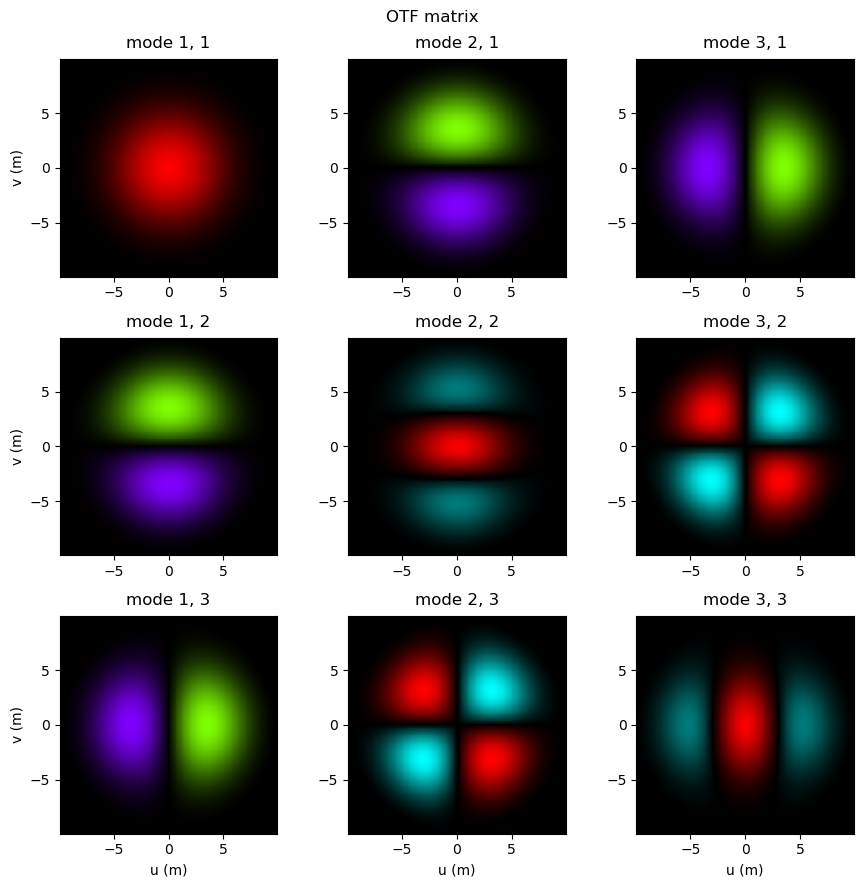

In [7]:
otf.compute()

fig, axs = plt.subplots(ncols=3, nrows=3, figsize=(9,9))
for i in range(3):
    for j in range(3):
        hc.imshow_field(otf.full_ccpupils[i,j], grid = otf.egrid, ax=axs[i,j])
        axs[i,j].text(0.5, 1.05, f'mode {j+1}, {i+1}', 
                       size=12, ha='center', transform=axs[i,j].transAxes)
        axs[2,j].set_xlabel('u (m)')
    axs[i,0].set_ylabel('v (m)')

fig.suptitle('OTF matrix')
fig.tight_layout()
plt.show()

These are the spatial-frequency sampling functions! The dot product of the mutual coherence function $\Gamma$ with these sampling functions are the spatial information that are actually sampled: $\int \Gamma \cdot \mathbf{K}$.

In the context of the previous examples of point sources offsetted by 5 mas and 50 mas, 50 mas one had high-frequency fringes, which would be missed by these low-order sampling functions of a 3-port lantern. This means the light would not couple much into the 3-port lantern device; this makes sense, this is nearly 2 $\lambda/D$, out of field-of-view of the 3-port lantern!

`scene.SceneProjector` class helps with this calculation.

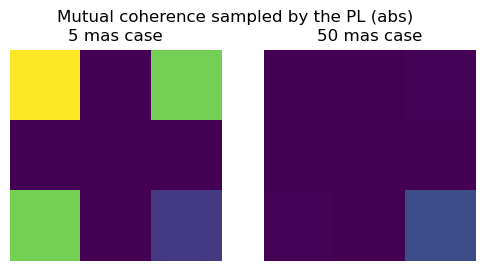

In [8]:
from PLsim.scene import SceneProjector

sp = SceneProjector(otf, scene)

projected = sp.compute_point(xoffset, yoffset)[:,:,0]
projected2 = sp.compute_point(xoffset2, yoffset2)[:,:,0]

fig, axs = plt.subplots(ncols=2, figsize=(6,3))
axs[0].imshow(np.abs(projected), vmin=0, vmax=1e-7)
axs[1].imshow(np.abs(projected2), vmin=0, vmax=1e-7)
for ax in axs: ax.axis('off')
axs[0].set_title('5 mas case')
axs[1].set_title('50 mas case')
fig.suptitle('Mutual coherence sampled by the PL (abs)')
plt.show()

However, not all these elements  $\int \Gamma \cdot \mathbf{K}$ can be observed. The observables are described as diagonal components of these sampled matrix rotated by the transfer matrix of the mode sorting device, $U$, which describes how each spatial mode (here the LP01, LP11a, and LP11b modes) is mapped to each output. 

#### ** analogy to aperture masking interferometry

[Kim et al. 2024a](https://iopscience.iop.org/article/10.3847/1538-4357/ad245e) made an analogy of these spatial frequency sampling functions with aperture masking interferometry (AMI). Here we show a brief example. `PLsim` supports AMI simulations as well, but assuming fiber-fed.

(2, 15625)


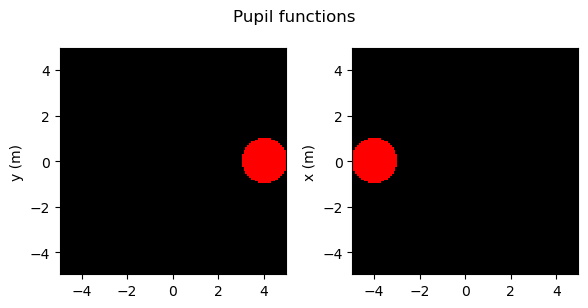

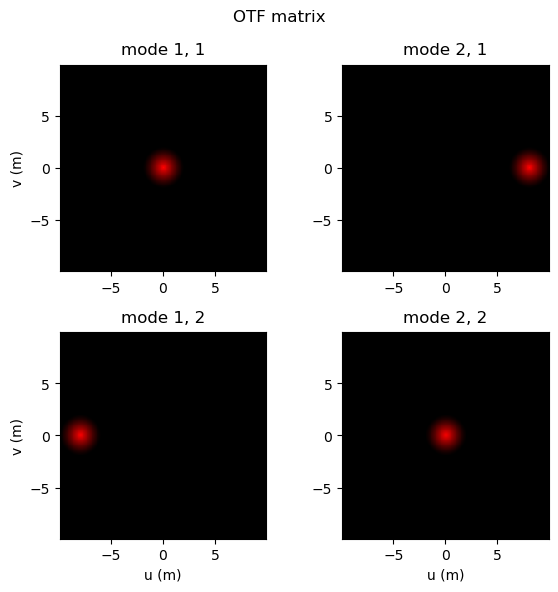

In [9]:
mask_locs = [(4, 0), (-4, 0)] # two-hole aperture mask separated by 8m
mask_radius = 1
otf_ami = OTF.from_aperture_masks(mask_locs, mask_radius, pupil_grid)

fig, axs = plt.subplots(ncols=2, figsize=(6,3))
for i in range(2):
    hc.imshow_field(otf_ami.pupil_functions[i], grid = pupil_grid, ax=axs[i])
    axs[i].set_ylabel('x (m)')
fig.suptitle('Pupil functions')
axs[0].set_ylabel('y (m)')
fig.tight_layout()
plt.show()

otf_ami.compute()

fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(6,6))
for i in range(2):
    for j in range(2):
        hc.imshow_field(otf_ami.full_ccpupils[i,j], grid = otf_ami.egrid, ax=axs[i,j])
        axs[i,j].text(0.5, 1.05, f'mode {j+1}, {i+1}', 
                       size=12, ha='center', transform=axs[i,j].transAxes)
        axs[1,j].set_xlabel('u (m)')
    axs[i,0].set_ylabel('v (m)')

fig.suptitle('OTF matrix')
fig.tight_layout()
plt.show()

For the AMI, by interfering light transmitted by two different apertures, one can access the off-diagonal components of the OTF matrix.

### 3. System's transfer matrix $U$

`PLsim` has the `system` module, which includes useful functions to generate the system's transfer matrix.

A mode-selective photonic lantern maps each LP mode to each output, so the transfer matrix is the identity matrix. A standard lantern may have any transfer matrix determined by the design and construction, which is described by a nearly unitary matrix.

The transfer matrix can be modified by feeding PL's outputs to a photonic integrated circuit (PIC) to introduce interference between the outputs, or oversample so that off-diagonal components can be accessed. 

In this notebook I will show simple cases, a 3-port mode-selective lantern vs standard lantern.

In [13]:
from PLsim.system.lantern import generate_unitary_matrix
mspl_matrix = np.eye(3)[np.newaxis] # last axis is wavelength; this notebook assumes monochromatic
spl_matrix  = generate_unitary_matrix(3)[np.newaxis]

Now the transfer matrices are generated. Define the `Device` class with these transfer matrices as inputs.

In [14]:
from PLsim.system.device import Device

mspl_device = Device(mspl_matrix)
spl_device  = Device(spl_matrix)

Device initialized with:
  Lantern matrices: (1, 3, 3)
  PIC matrices: None
  Wavelengths: 1
Device initialized with:
  Lantern matrices: (1, 3, 3)
  PIC matrices: None
  Wavelengths: 1


Calculate the observables

In [15]:
mspl_output = mspl_device.calculate_outputs(projected)[0]
spl_output  = spl_device.calculate_outputs(projected)[0]

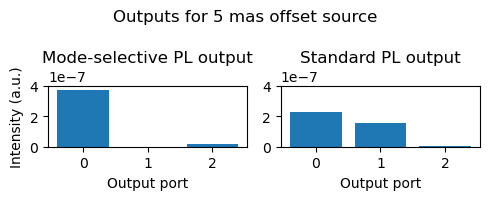

In [16]:
fig, axs = plt.subplots(ncols=2, figsize=(5,2))
axs[0].bar(range(3), mspl_output)
axs[0].set_title('Mode-selective PL output')
axs[0].set_xlabel('Output port')
axs[0].set_ylabel('Intensity (a.u.)')
axs[1].bar(range(3), spl_output)
axs[1].set_title('Standard PL output')
axs[1].set_xlabel('Output port')
for ax in axs: ax.set_ylim([0, 4e-7])
fig.suptitle('Outputs for 5 mas offset source')
fig.tight_layout()
plt.show()

### Concluding remarks

This notebook shows the basic principle of mode-based imaging in astronomical interferometric context. Although only the simple cases are illustrated here, `PLsim` can efficiently simulate the observables, even for high-mode-count devices (~19), multi-wavelengths, and complex scenes, and with wavefront aberrations. The other tutorial notebooks will show more complex examples.